In [1]:
from sklearn.metrics import mean_squared_error, brier_score_loss, f1_score
from ff_custom_scripts import *
import shap
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, CatBoostRegressor


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='keep')

alldata = pd.concat([train, test,leaderboard,holdout]) 

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

(1172, 1437) (294, 1437) (530, 1437) (1111, 1437)


In [3]:
def run_model(train, test, target='gpa', classifier=False):

    catcols = train.select_dtypes(include=['category']).columns
    train[catcols] = train[catcols].astype(str)
    test[catcols] = test[catcols].astype(str)

    X_train, y_train = prepare_data(train, target)
    X_test, y_test = prepare_data(test, target)

    print(X_train.shape, y_train.shape)

    numerical_features = cols_per_type(X_train, 'Continuous')
    print(f'N. of numerical features: {len(numerical_features)}')
    ordinal_features = cols_per_type(X_train, 'Ordered Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    print(f'N. of binary features: {len(binary_features)}')
    categorical_features = cols_per_type(X_train, 'Unordered Categorical')
    print(f'N. of categorical features: {len(categorical_features)}')
    print(f'N. of ordinal features: {len(ordinal_features)}')
    
    iter = 20_000

    if classifier:
        catboost = CatBoostClassifier(
          thread_count=-1, cat_features=categorical_features, verbose=0,random_seed=42)
    else:
        
        catboost = CatBoostRegressor(thread_count=-1, cat_features=categorical_features, random_seed=123,
                                     iterations=iter, early_stopping_rounds=iter*0.1,verbose=10)

    model = catboost.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=0)

    return model


def mse_error(model, data, target='gpa'):
    X, y = prepare_data(data, target)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# Eviction

In [4]:
model_eviction = run_model(train,test,target='eviction', classifier=True)

(1167, 1431) (1167,)
N. of numerical features: 135
N. of binary features: 692
N. of categorical features: 135
N. of ordinal features: 469


In [5]:
score_model(model_eviction, target='eviction',test=test, leaderboard=leaderboard, classifier=True, holdout=holdout)

Scores without threshold adjusment
Test Brier: 0.0514
Test F1: 0.0000
Leaderboard Brier: 0.0566
Number of positive predictions: 0.0
>> Leaderboard F1: 0.0000
Leaderboard Accuracy: 0.9434
Leaderboard Recall: 0.0000
Holdout Brier: 0.0589
Holdout F1: 0.0000


In [6]:
holdout.eviction.value_counts()

False    1038
True       65
Name: eviction, dtype: int64

Scores with threshold adjusment


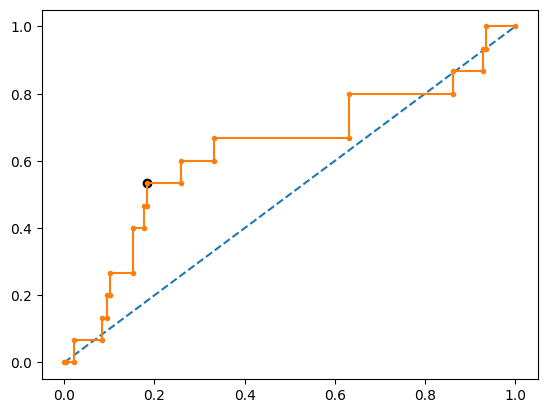

Threshold=0.063, FPR=0.184, TPR=0.533
Test brier: 0.202
Test F1: 0.192
Leaderboard Brier: 0.247
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85       500
         1.0       0.10      0.43      0.17        30

    accuracy                           0.75       530
   macro avg       0.53      0.60      0.51       530
weighted avg       0.91      0.75      0.82       530

Leaderboard F1: 0.166
Holdout Brier: 0.188
Holdout F1: 0.195


In [7]:
def score_classifier(model,target,test,leaderboard,holdout=None):
    # load data
    X_test, y_test = prepare_data(test, target)
    X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
    print('Scores with threshold adjusment')
    
    ## get threshold for optimal FPR
    yhat = model.predict_proba(X_test)
    yhat = yhat[:, 1]
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    # calculate AUC
    # auc = roc_auc_score(y_test, yhat)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # print('AUC: %.3f' % auc)
    # plot optimal threshold as point
    # find the optimal threshold using youden's j statistic
    ix = np.argmax(tpr - fpr)
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black')
    pyplot.show()
    # print value of optimal threshold
    print('Threshold=%.3f, FPR=%.3f, TPR=%.3f' % (thresholds[ix], fpr[ix], tpr[ix]))
    
    # score test
    yhat = model.predict_proba(X_test)
    yhat = yhat[:, 1]
    yhat = yhat > thresholds[ix]
    # print(classification_report(y_test, yhat))
    brier = brier_score_loss(y_test, yhat)
    print('Test brier: %.3f' % brier)
    f1 = f1_score(y_test, yhat)
    print('Test F1: %.3f' % f1)

    # score leaderboard
    yhat = model.predict_proba(X_leaderboard)
    yhat = yhat[:, 1]
    yhat = yhat > thresholds[ix]
    brier = brier_score_loss(y_leaderboard, yhat)
    print('Leaderboard Brier: %.3f' % brier)
    print(classification_report(y_leaderboard, yhat))
    f1 = f1_score(y_leaderboard, yhat)
    print('Leaderboard F1: %.3f' % f1)

    if holdout is not None:
        X_holdout, y_holdout = prepare_data(holdout, target)
        y_holdout = y_holdout.astype(int)
        yhat = model.predict_proba(X_holdout)
        yhat = yhat[:, 1]
        yhat = yhat > thresholds[ix]
        brier = brier_score_loss(y_holdout, yhat)
        print('Holdout Brier: %.3f' % brier)
        f1 = f1_score(y_holdout, yhat)
        print('Holdout F1: %.3f' % f1)
        
score_classifier(model_eviction, target='eviction', holdout=holdout, test=test,leaderboard=leaderboard)

# Shap values with all data

In [8]:
final_model = run_model(alldata,leaderboard,target='eviction', classifier=True)

(3092, 1431) (3092,)
N. of numerical features: 135
N. of binary features: 692
N. of categorical features: 135
N. of ordinal features: 469


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


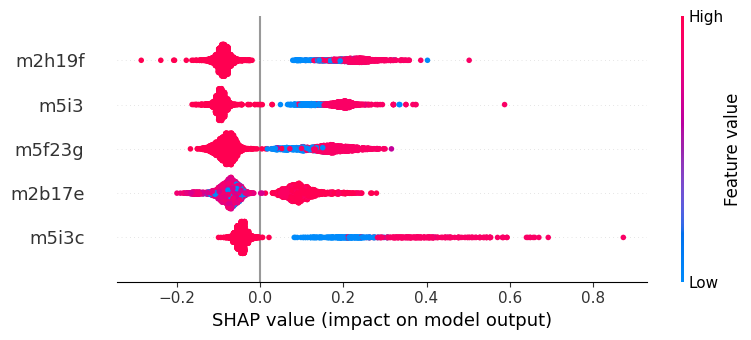

In [9]:
# plot shap values of final model
X, y = prepare_data(alldata, 'eviction')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

top_features = 5

shap.summary_plot(shap_values, X, max_display=top_features)

# feat names of top 10 features
top = X.columns[np.argsort(-np.abs(shap_values).mean(0))[:top_features]]

In [10]:
def feat_2id(feats,meta=pd.read_csv('../metadata/variables.csv',index_col=0)):
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in feats]
    df = pd.DataFrame(top_n_vars, index=feats, columns=['varlab'])
    return df

    
feat_2id(top).to_csv('../metadata/topfeat_eviction.csv')
feat_2id(top)

,varlab
m2h19f,"In past year, did you-Not pay full gas/oil/ele..."
m5i3,I3. Have completed training programs or years ...
m5f23g,F23G. Borrowed money from friends/family to he...
m2b17e,On a scale of 1-(least like) to 5-(most like) ...
m5i3c,I3C. You received any kind of employment couns...
